# Import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import ast

from datetime import datetime
import time
CURRENT_DATE = pd.to_datetime('14/03/2020')

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def get_list(list_string):
    result_list = ast.literal_eval(list_string)
    return result_list

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Data Preprocessing

In [4]:
# на всякий случай, заново подгружаем данные
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

#data['Cuisine Style 1'] = data['Cuisine Style'].str[2:-2].str.split("', '").fillna("Usual")

In [5]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
15122,id_125,Budapest,"['European', 'Eastern European', 'Central Euro...",126.0,$$ - $$$,1093.0,"[['Nice dinner', 'Amazing!'], ['01/06/2018', '...",/Restaurant_Review-g274887-d798846-Reviews-Bel...,d798846,1,4.5
10689,id_1033,Dublin,"['Irish', 'International', 'European']",1035.0,$$ - $$$,230.0,[['Appalling breakast for which I was charged....,/Restaurant_Review-g186605-d1553821-Reviews-Ca...,d1553821,1,3.5
7581,id_7581,Paris,NaN,10388.0,NaN,9.0,"[['Very good fish in the sushi, service shoul....",/Restaurant_Review-g187147-d4809044-Reviews-Le...,d4809044,0,0.0
39066,id_774,Munich,"['Italian', 'Mediterranean']",782.0,$$$$,59.0,"[['Fine dining', 'Surprisingly good and stylis...",/Restaurant_Review-g187309-d1071094-Reviews-Pe...,d1071094,1,4.5
22278,id_976,Rome,"['Italian', 'Mediterranean', 'Wine Bar', 'Vege...",977.0,$$ - $$$,668.0,"[['A quirky must visit', 'Genuine and deliciou...",/Restaurant_Review-g187791-d793195-Reviews-Giu...,d793195,1,4.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [7]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    
    #df_output.drop(['','',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    
    df_output['Cuisine Style isNAN'] = pd.isna(df_output['Cuisine Style']).astype('uint8')
    #df_output['Price Range isNAN'] = pd.isna(df_output['Price Range']).astype('uint8')
    df_output['Number of Reviews isNAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    df_output['Reviews isNAN'] = pd.isna(df_output['Reviews']).astype('uint8')
    
    df_output['Number of Reviews'] = df_output['Number of Reviews'].fillna(0)
    #df_output['Price Range'] = df_output['Price Range'].fillna('$$ - $$$')
    
    
    # ################### 3. Feature Engineering ####################################################
    
    ## видоизменение представления ценовых диапазонов ресторанов
    price_range_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
    df_output['Price Range'] = df_output['Price Range'].map(price_range_dict)
    
    ## создание признака "население городов"
    population = {'Paris': 2190327, 'Stockholm': 961609, 'London': 8908081, 'Berlin': 3644826, 'Munich': 1456039, 'Oporto': 237591,
                  'Milan': 1378689,'Bratislava': 432864, 'Vienna': 1821582, 'Rome': 4355725, 'Barcelona': 1620343, 'Madrid': 3223334,
                  'Dublin': 1173179,'Brussels': 179277, 'Zurich': 428737, 'Warsaw': 1758143, 'Budapest': 1752286, 'Copenhagen': 615993,
                  'Amsterdam': 857713,'Lyon': 506615, 'Hamburg': 1841179,'Lisbon': 505526, 'Prague': 1301132, 'Oslo': 673469,
                  'Helsinki': 643272,'Edinburgh': 488100,'Geneva': 200548, 'Ljubljana': 284355,'Athens': 664046, 'Luxembourg': 115227,
                  'Krakow': 769498}
    df_output['Population'] = df_output['City'].map(population)
    
    city_country = {'London': 'UK','Paris': 'France','Madrid': 'Spain','Barcelona': 'Spain','Berlin': 'Germany','Milan': 'Italy',
                    'Rome': 'Italy','Prague': 'Czech','Lisbon': 'Portugalia','Vienna': 'Austria','Amsterdam': 'Nederlands','Brussels': 'Belgium ',
                    'Hamburg': 'Germany','Munich': 'Germany','Lyon': 'France','Stockholm': 'Sweden','Budapest': 'Hungary','Warsaw': 'Poland',
                    'Dublin': 'Ireland' ,'Copenhagen': 'Denmark','Athens': 'Greece','Edinburgh': 'Schotland','Zurich': 'Switzerland','Oporto': 'Portugal',
                    'Geneva': 'Switzerland','Krakow': 'Poland','Oslo': 'Norway','Helsinki': 'Finland','Bratislava': 'Slovakia','Luxembourg': 'Luxembourg',
                    'Ljubljana': 'Slovenija'}
    df_output['Country'] = df_output['City'].map(city_country)
    
    ## создание признака "количество ресторанов в городе"
    df_output['Rest per City'] = df_output['City'].map(df_output.groupby(['City'])['City'].count().to_dict())
    
    ## создание признака "количество ресторанов на человека в городе"
    df_output['Pop per (Rest per City)'] = df_output['City'].map(population) / df_output['Rest per City']
    
    ## создание признака "количество отзывов к количеству ресторанов на человека в городе"
    df_output['Rev per (Rest per Pers)'] = df_output['Number of Reviews'] / df_output['Pop per (Rest per City)']
    
    ## создание признака "относительный рэнкинг"
    df_output['Relative Ranking'] = df_output['Ranking'] / df_output['Rest per City']
    
    ## создание признака "ценовой диапазон vs относительный рэнкинг"
    #df_output['Relative Price Range'] = df_output['Price Range'] / df_output['Relative Ranking']
    #df_output['Relative Price Range isNa'] = pd.isna(df_output['Relative Price Range']).astype('uint8')
    #df_output['Relative Price Range'] = df_output['Relative Price Range'].fillna(df_output['Relative Price Range'].median())
    
    ## создание признака "столица / не столица"
    capitals = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague', 'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Stockholm','Budapest', 
                'Warsaw', 'Dublin', 'Copenhagen', 'Athens', 'Oslo', 'Helsinki', 'Bratislava', 'Luxembourg', 'Ljubljana', 'Edinburgh']
    df_output['Capitals'] = df_output['City'].apply(lambda x: 1 if x in(capitals) else 0)
    
    ## создание признака "код города"
    cities_le = LabelEncoder()
    cities_le.fit(df_output['City'])
    df_output['City Code'] = cities_le.transform(df_output['City'])
    countries_le = LabelEncoder()
    countries_le.fit(df_output['Country'])
    df_output['Country Code'] = countries_le.transform(df_output['Country'])
    
    ## создание признака "количество типов кухонь, представленных в ресторане"
    df_output['Cuisine Style New'] = df_output['Cuisine Style'].str[2:-2].str.split("', '").str.len().fillna(1)
    
    ## создание признака "сетевой ресторан"
    restaurant_chain = set()
    for chain in df_output['Restaurant_id']:
        restaurant_chain.update(chain)
    def find_item(cell):
        if item in cell:
            return 1
        return 0
    for item in restaurant_chain:
        df_output['Rest Chain'] = df_output['Restaurant_id'].apply(find_item)  
    
    ## создание признака "ID URL_TA"
    df_output['URL_TA New'] = df_output['URL_TA'].apply(lambda x: float(x[20:26]))
    
    ## создание признака "ID ID_TA"
    df_output['ID_TA New'] = df_output['ID_TA'].apply(lambda x: float(x[1:]))
    
    ## создание новых признаков на основе двух последних дат отзывов
    def nan_to_default_date(list_string):
        try:
            list_string = list_string.replace('[nan', "['01/01/2000'")
            list_string = list_string.replace('nan]', "'01/01/2000']")
            list_string = list_string.replace('[]', "['01/01/2000', '01/01/2000']")
        except:
            list_string = "[['None Review', 'None Review'], ['01/01/2000', '01/01/2000']]"
        return list_string
    df_output['Reviews'] = df_output['Reviews'].apply(nan_to_default_date)
    last_review = []
    last_review_date = []
    prelast_review = []
    prelast_review_date = []
    for reviews in df_output['Reviews']:
        reviews_list = get_list(reviews)
        if (len(reviews_list) == 2):
            if (len(reviews_list[0]) == 2 and len(reviews_list[1]) == 2):
                last_review.append(reviews_list[0][0])
                last_review_date.append(reviews_list[1][0])
                prelast_review.append(reviews_list[0][1])
                prelast_review_date.append(reviews_list[1][1])
            elif (len(reviews_list[0]) == 1 and len(reviews_list[1]) == 1):
                last_review.append(reviews_list[0][0])
                last_review_date.append(reviews_list[1][0])
                prelast_review.append('None review')
                prelast_review_date.append('01/01/2000')
            else:
                print(reviews_list)
    df_output['Last Review'] = last_review
    df_output['Last Review Date'] = last_review_date
    df_output['Prelast Review'] = prelast_review
    df_output['Prelast Review Date'] = prelast_review_date
    df_output['Last Review Date'] = pd.to_datetime(df_output['Last Review Date'])
    df_output['Prelast Review Date'] = pd.to_datetime(df_output['Prelast Review Date'])
    df_output['Days Between Reviews'] = (df_output['Last Review Date'] - df_output['Prelast Review Date'])
    def get_days(timedelta):
        return timedelta.days
    df_output['Days Between Reviews'] = abs(df_output['Days Between Reviews'].apply(get_days))
    df_output['Days Since Last Review'] = df_output['Last Review Date'].apply(lambda date: CURRENT_DATE - date)
    df_output['Days Since Last Review'] = df_output['Days Since Last Review'].apply(get_days)
    
    
    # ################### 4. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    
    df_output = pd.get_dummies(df_output, columns = ['Price Range'], dummy_na = True)
    df_output = pd.get_dummies(df_output, columns = ['Capitals'], dummy_na = False)
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    
    object_columns = [s for s in df_output.columns if (df_output[s].dtypes == 'object') or (df_output[s].dtypes == 'datetime64[ns]')]
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    
    return df_output

In [8]:
df_preproc = preproc_data(data)

In [9]:
df_preproc.sample(5)

,Ranking,Number of Reviews,sample,Rating,Cuisine Style isNAN,Number of Reviews isNAN,Reviews isNAN,Population,Rest per City,Pop per (Rest per City),...,URL_TA New,ID_TA New,Days Between Reviews,Days Since Last Review,Price Range_1.0,Price Range_2.0,Price Range_3.0,Price Range_nan,Capitals_0,Capitals_1
2990,12089.0,27.0,0,0.0,1,0,0,8908081,7193,1238.437509,...,186338.0,1501200.0,415,1002,0,0,0,1,0,1
6321,5991.0,3.0,0,0.0,1,0,0,3644826,2705,1347.440296,...,187323.0,1357805.0,3913,3465,0,0,0,1,0,1
34113,5883.0,0.0,1,4.0,0,1,0,1620343,3395,477.273343,...,187497.0,13170374.0,0,7378,0,1,0,0,1,0
47900,3582.0,4.0,1,5.0,0,0,0,1378689,2694,511.762806,...,187849.0,10637942.0,0,7378,1,0,0,0,1,0
36778,1619.0,196.0,1,4.5,0,0,0,8908081,7193,1238.437509,...,186338.0,780116.0,15,798,0,1,0,0,0,1


In [10]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
Ranking                    50000 non-null float64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
Cuisine Style isNAN        50000 non-null uint8
Number of Reviews isNAN    50000 non-null uint8
Reviews isNAN              50000 non-null uint8
Population                 50000 non-null int64
Rest per City              50000 non-null int64
Pop per (Rest per City)    50000 non-null float64
Rev per (Rest per Pers)    50000 non-null float64
Relative Ranking           50000 non-null float64
City Code                  50000 non-null int64
Country Code               50000 non-null int64
Cuisine Style New          50000 non-null float64
Rest Chain                 50000 non-null int64
URL_TA New                 50000 non-null float64
ID_TA New                  50000 non-null float64
Days Betw

In [11]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)
y = train_data.Rating.values
X = train_data.drop(['Rating'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [12]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [13]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 25), (40000, 25), (40000, 24), (30000, 24), (10000, 24))

# Model

In [14]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [15]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [16]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [17]:
# Округляем полученные значения рейтингов
def round_d(rec):
    if rec <0.25:
        return 0
    elif 0.25<rec<=0.75:
        return 0.5
    elif 0.75<rec<=1.25:
        return 1
    elif 1.25<rec<=1.75:
        return 1.5
    elif 1.75<rec<=2.25:
        return 2
    elif 2.25<rec<=2.75:
        return 2.5
    elif 2.75<rec<=3.25:
        return 3
    elif 3.25<rec<=3.75:
        return 3.5
    elif 3.75<rec<=4.25:
        return 4
    elif 4.25<rec<=4.75:
        return 4.5
    else:
        return 5
    
for i in range(y_pred.size):
    y_pred[i]=round_d(y_pred[i])

In [18]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.16805


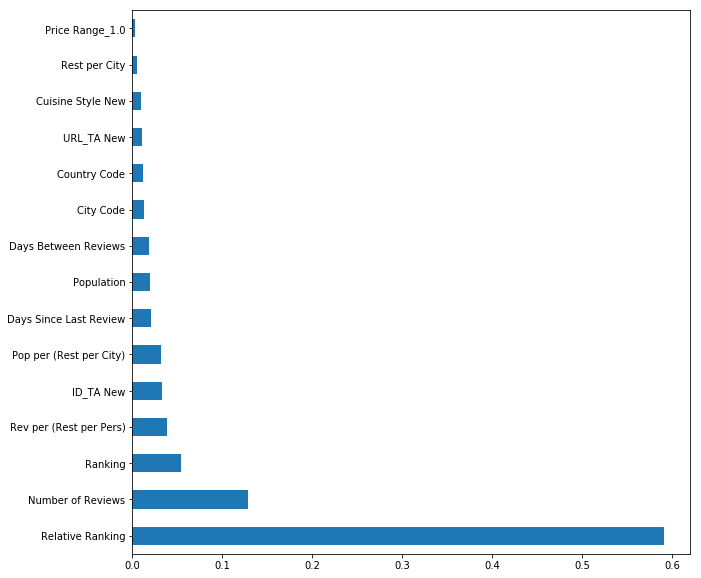

In [19]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [20]:
# Обучаем модель на всех исходных данных
model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)

In [21]:
# Запускаем на данных по заданию
test_df = df_preproc.query('sample == 0').drop(['sample'], axis=1)
test_df = test_df.drop(['Rating'], axis=1)
predict_submission = model.predict(test_df)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [22]:
# Округляем
sample_submission['Rating'] = predict_submission
sample_submission['Rating'] = sample_submission['Rating'].apply(round_d)

In [23]:
# Выгружаем в файл
sample_submission.to_csv('submission.csv', index=False)